# Code Test Part II

## Get and unzip the data
if the data 'namesbystate.zip' is already in the root dir(same dir as this code), there will be no downloading

In [2]:
import urllib
import urllib2
import os

if 'namesbystate.zip' in os.listdir('.'):
    pass
else:
    url = 'http://www.ssa.gov/oact/babynames/state/namesbystate.zip'
    print "downloading data"
    f = urllib2.urlopen(url)
    data = f.read()
    with open("namesbystate.zip", "wb") as g:
        g.write(data)
    g.close()

import zipfile
archive = zipfile.ZipFile('namesbystate.zip', 'r')

## A) Descriptive analysis

### 1.  Please describe the format of the data files. Can you identify any limitations or distortions of the data?

Answer: the data is grouped by states into 51 files with each one corresponding data collected from that state over 1910-2015. For each file, there are 5 attributes, which are the *state name*, *gender(F or M)*, *year*, *name* and *count*, where only names with count >= 5 are included. 

The limitation of the data is the attribute *count* is absolute count. It fails to consider the population of the state. If we want to check relative popularity of names in across states, we have to normalized it.

From the description in the data source website, we also know that this data records only people who have applied Social Security Card(SSN) and note that many people born before 1937 never applied SSN

Also note from the source that names with different spellings are not combined, which means Caitlin, Caitlyn, Kaitlin, Kaitlyn, Kaitlynn, Katelyn, and Katelynn are considered as different names

### 2.  What is the most popular name of all time? (Of either gender.)

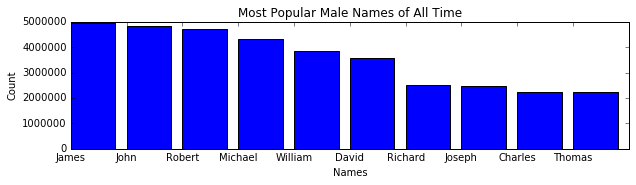

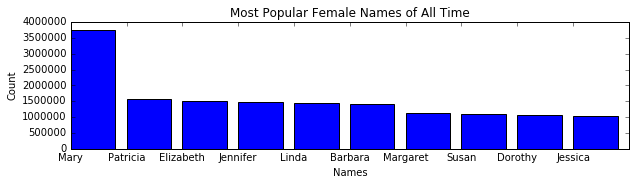

In [5]:
import pandas as pd
import numpy as np
import operator as op
from collections import Counter
from matplotlib import pyplot as plot
from pylab import rcParams
%matplotlib inline

# given a state name, this function reads the file and store it into pandas dataframe
def openfile(archive, state):
    table = []
    header = ['state', 'gender', 'year', 'name', 'count']
    f = archive.open('%s.TXT' % state)
    for line in f:
        table.append(line.strip().split(','))
    f.close()
    df = pd.DataFrame(table, columns = header)
    df[['year', 'count']] = df[['year', 'count']].astype(int)
    return df

# given state name, get the counter of name of all time for both genders
def get_counter(state):
    df = openfile(archive, state)
    subset_female = df[df.gender == 'F']
    subset_male = df[df.gender == 'M']
    female_counter = Counter(dict(subset_female.groupby(['name'])['count'].aggregate(np.sum)))
    male_counter = Counter(dict(subset_male.groupby(['name'])['count'].aggregate(np.sum)))
    return female_counter, male_counter

states_name = [i[:2] for i in archive.namelist() if i.endswith('TXT')]
male_counter_list = []
female_counter_list = []
for state in states_name:
    female_counter, male_counter = get_counter(state)
    female_counter_list.append(female_counter)
    male_counter_list.append(male_counter)

female_names = reduce(op.add, female_counter_list)
male_names = reduce(op.add, male_counter_list)

a = male_names.most_common(10)
b = female_names.most_common(10)

rcParams['figure.figsize'] = 10, 5
plot.subplot(211)
plot.xlabel('Names')
plot.ylabel('Count')
plot.title('Most Popular Male Names of All Time')
plot.bar(range(10), map(lambda x: x[1], a))
plot.xticks(range(10), map(lambda x: x[0], a))
plot.show()

plot.subplot(212)
plot.xlabel('Names')
plot.ylabel('Count')
plot.title('Most Popular Female Names of All Time')
plot.bar(range(10), map(lambda x: x[1], b))
plot.xticks(range(10), map(lambda x: x[0], b))
plot.show()



### 3.  What is the most gender ambiguous name in 2013? 1945?

Let me define gender ambigous name as the name that appears in both Males and Females with at least 10% proportion count in either gender. 
For example, names such as Emma(Female 20,000, male 5) are thus not counted as ambiguous name.

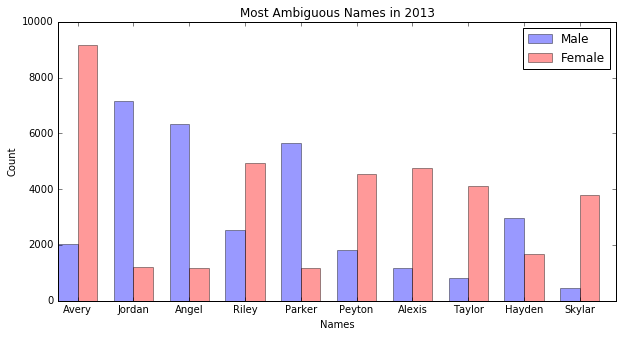

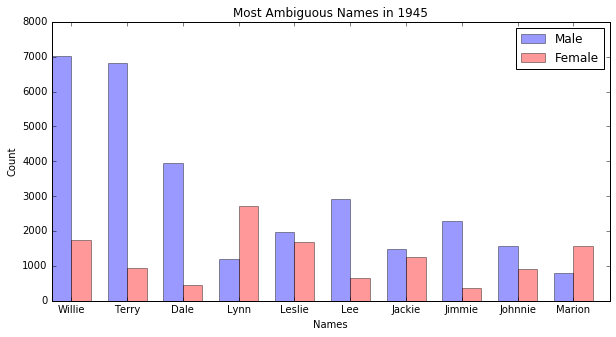

In [6]:
# get the counter of male and female given year
def count_by_year(year):
    counter_list_male = []
    counter_list_female = []
    for state in states_name:
        df = openfile(archive, state)
        subset = df[df['year'] == year]
        subset_male = subset[subset['gender'] == 'M']
        subset_female = subset[subset['gender'] == 'F']
        female_counter = Counter(dict(subset_female.groupby(['name'])['count'].aggregate(np.sum)))
        male_counter = Counter(dict(subset_male.groupby(['name'])['count'].aggregate(np.sum)))
        counter_list_male.append(male_counter)
        counter_list_female.append(female_counter)
    return reduce(op.add, counter_list_male), reduce(op.add, counter_list_female)

# the ratio of count of  male and female should within a certain range to conclude that the name is an ambiguous name
def valid_name(male_count, female_count):
    MAX = max(male_count, female_count)
    MIN = min(male_count, female_count)
    return float(MAX) / MIN < 10

# given year, output ambiguous names and their count
def get_ambigous_names(year):
    male_year, female_year = count_by_year(year)
    total_year = male_year + female_year
    candidate_names = set(list((male_year & female_year).elements()))
    ambigous_count = Counter()
    for i in candidate_names:
        ambigous_count[i] = total_year[i]
        true_ambiguous = [(i[0], male_year[i[0]], female_year[i[0]]) for i in ambigous_count.most_common() if valid_name(male_year[i[0]], female_year[i[0]])]
    return true_ambiguous

ambiguous_2013 = get_ambigous_names(2013)
ambiguous_1945 = get_ambigous_names(1945)

n_groups = 10
male = map(lambda x: x[1], ambiguous_2013)[:10]
female = map(lambda x: x[2], ambiguous_2013)[:10]
fig, ax = plot.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.4
rects1 = plot.bar(index, male, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Male')

rects2 = plot.bar(index + bar_width, female, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Female')

plot.xlabel('Names')
plot.ylabel('Count')
plot.title('Most Ambiguous Names in 2013')
plot.xticks(index + bar_width, map(lambda x: x[0], ambiguous_2013))
plot.legend()
plot.show()

male = map(lambda x: x[1], ambiguous_1945)[:10]
female = map(lambda x: x[2], ambiguous_1945)[:10]
fig, ax = plot.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.4
rects1 = plot.bar(index, male, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Male')

rects2 = plot.bar(index + bar_width, female, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Female')

plot.xlabel('Names')
plot.ylabel('Count')
plot.title('Most Ambiguous Names in 1945')
plot.xticks(index + bar_width, map(lambda x: x[0], ambiguous_1945))
plot.legend()
plot.show()

### 4.  Of the names represented in the data, find the name that has had the largest percentage increase in popularity since 1980. Largest decrease?


Note that I do not consider new names that only appears in year 2015 and no occurrence in year 1980, which would be an infinite percentage increase. This part I just want to focus on names that are both used in 1980 and 2015.

Let's consider only names that has more than 1000 counts in both 1980 and 2015, since there is no interest to know a name that had count 4 in 1980 and has 10 in 2015. 

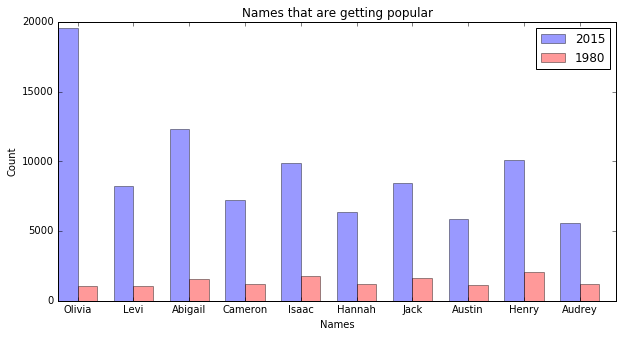

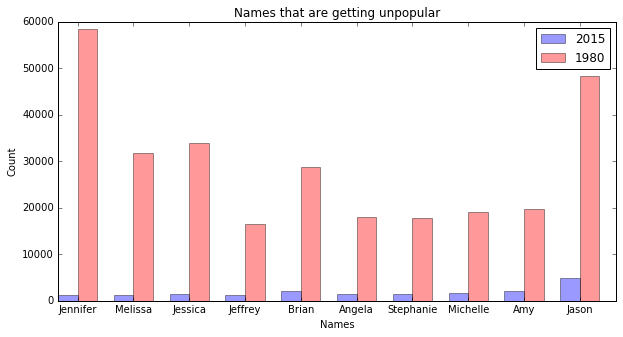

In [16]:
# filter a counter with a cutoff count
def get_valid_counter(total_counter):
    valid_counter = Counter()
    valid_names = filter(lambda x: total_counter[x] > 1000, total_counter)
    for i in valid_names:
        valid_counter[i] = total_counter[i]
    return valid_counter

male_counter_1980, female_counter_1980 = count_by_year(1980)
total_counter_1980 = male_counter_1980 + female_counter_1980
names_1980 = filter(lambda x: total_counter_1980[x] > 1000, total_counter_1980)

male_counter_2015, female_counter_2015 = count_by_year(2015)
total_counter_2015 = male_counter_2015 + female_counter_2015
names_2015 = filter(lambda x: total_counter_2015[x] > 1000, total_counter_2015)

ratio_dict = dict()
for name in set(names_1980).intersection(set(names_2015)) :
    ratio_dict[name] = float(total_counter_2015[name]) / total_counter_1980[name]

from heapq import nlargest, nsmallest
increasing_names = nlargest(10, ratio_dict, key = lambda k: ratio_dict[k])
decreasing_names = nsmallest(10, ratio_dict, key = lambda k: ratio_dict[k])

n_groups = 10
year_2015 = [total_counter_2015[i] for i in increasing_names]
year_1980 = [total_counter_1980[i] for i in increasing_names]
fig, ax = plot.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.4
rects1 = plot.bar(index, year_2015, bar_width,
                 alpha=opacity,
                 color='b',
                 label='2015')

rects2 = plot.bar(index + bar_width, year_1980, bar_width,
                 alpha=opacity,
                 color='r',
                 label='1980')

plot.xlabel('Names')
plot.ylabel('Count')
plot.title('Names that are getting popular')
plot.xticks(index + bar_width, increasing_names)
plot.legend()
plot.show()

year_2015 = [total_counter_2015[i] for i in decreasing_names]
year_1980 = [total_counter_1980[i] for i in decreasing_names]
fig, ax = plot.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.4
rects1 = plot.bar(index, year_2015, bar_width,
                 alpha=opacity,
                 color='b',
                 label='2015')

rects2 = plot.bar(index + bar_width, year_1980, bar_width,
                 alpha=opacity,
                 color='r',
                 label='1980')

plot.xlabel('Names')
plot.ylabel('Count')
plot.title('Names that are getting unpopular')
plot.xticks(index + bar_width, decreasing_names)
plot.legend()
plot.show()
    

### 5.  Can you identify names that may have had an even larger increase or decrease in popularity?

Let's only consider common names, by which I mean top 500 hundred male and female name pf all time. Among these names, I want to find names that are decreasing with an increasing order in the previous 3 years.

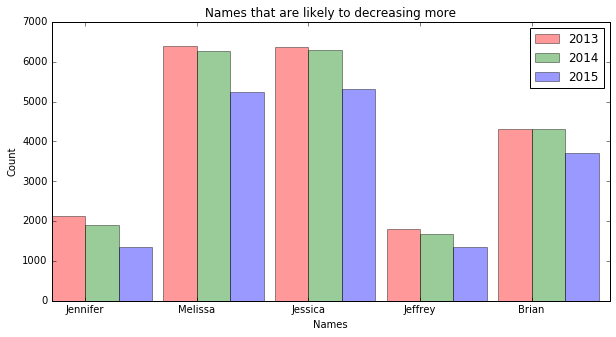

In [96]:
common_male_names = male_names.most_common(500)
common_female_names = female_names.most_common(500)

count_dict = dict()
for name in set(map(lambda x: x[0], common_male_names) + map(lambda x: x[0], common_female_names)):
    count_dict[name] = [0]*3
    
for num, year in enumerate([2013, 2014, 2015]):
    male_counter, female_counter = count_by_year(year)
    total_counter = male_counter + female_counter
    for key in count_dict.keys():
        count_dict[key][num] = total_counter[key]
        
valid_names = filter(lambda x: count_dict[x][2] > 1000, count_dict.keys())
valid_names = filter(lambda x: (count_dict[x][1] > count_dict[x][2]) and (count_dict[x][0] > count_dict[x][1]), valid_names)
valid_names = filter(lambda x: (float(count_dict[x][1]) / count_dict[x][0]) > (float(count_dict[x][2]) / count_dict[x][1]), valid_names)

second_order_ratio_dict = [(x, (float(count_dict[x][1]) / count_dict[x][0]) / (float(count_dict[x][2]) / count_dict[x][1])) for x in valid_names]
names = nlargest(5, second_order_ratio_dict, key = lambda k: k[1])

n_groups = 5
year_2013 = [count_dict[x[0]][0] for x in names]
year_2014 = [count_dict[x[0]][1] for x in names]
year_2015 = [count_dict[x[0]][2] for x in names]
fig, ax = plot.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.4
rects1 = plot.bar(index, year_2013, bar_width,
                 alpha=opacity,
                 color='r',
                 label='2013')

rects2 = plot.bar(index + bar_width, year_2014, bar_width,
                 alpha=opacity,
                 color='g',
                 label='2014')

rects3 = plot.bar(index + bar_width*2, year_2015, bar_width,
                 alpha=opacity,
                 color='b',
                 label='2015')
plot.xlabel('Names')
plot.ylabel('Count')
plot.title('Names that are likely to decreasing more')
plot.xticks(index + bar_width, decreasing_names)
plot.legend()
plot.show()
    

## B) Onward to Insight!

### 1. Value counts grows with years

this does not quite go along with the population growth. I think the reason is the names with value counts that are less than 5 are not counted, but there could be many people that fall into this category. 

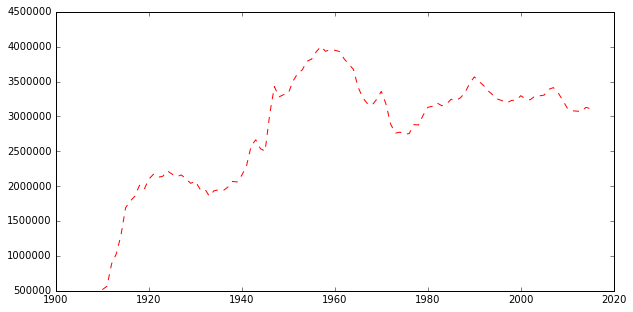

In [110]:
def get_counter_by_year(state):
    df = openfile(archive, state)
    counter = Counter(dict(df.groupby(['year'])['count'].aggregate(np.sum)))
    return counter

counter_list = []
for state in states_name:
    counter = get_counter_by_year(state)
    counter_list.append(counter)

count_by_year = reduce(op.add, counter_list)
plot.plot(list(count_by_year), [count_by_year[i] for i in list(count_by_year)], 'r--')
plot.show()

### 2. Number of unique names in MN(where I live)

The roar in 1990s meets the immigration history.

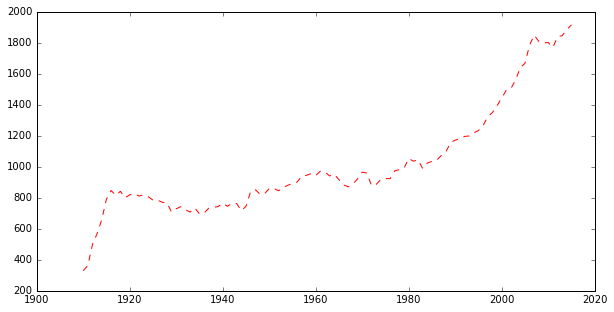

In [125]:
def get_unique_name_by_year(state):
    df = openfile(archive, state)
    counter = Counter(dict(df.groupby(['year']).size()))
    return counter

counter = get_unique_name_by_year('MN')
plot.plot(list(counter), [counter[i] for i in list(counter)], 'r--')
plot.show()

### 3. Number of unique names for male and female in MN

There are more unique names for girls than boys in MN

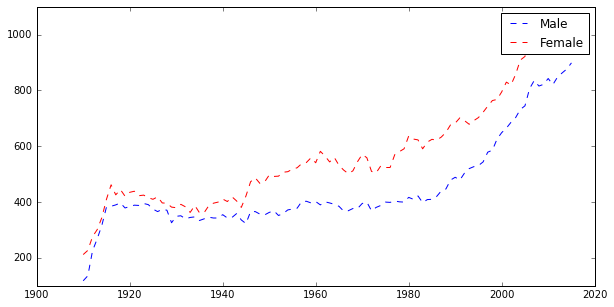

In [131]:
def get_unique_name_by_year(state):
    df = openfile(archive, state)
    male_counter = Counter(dict(df[df.gender == 'M'].groupby(['year']).size()))
    female_counter = Counter(dict(df[df.gender == 'F'].groupby(['year']).size()))
    return male_counter, female_counter

male_counter, female_counter = get_unique_name_by_year('MN')
plot.plot(list(male_counter),[male_counter[i] for i in list(male_counter)],'b--', label = 'Male') 
plot.plot(list(male_counter),[female_counter[i] for i in list(female_counter)],'r--', label = 'Female') 
plot.legend()
plot.show()